First of all, let's import necessary libraries.

In [244]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

Secondly, we have to check what this dataset contains

In [249]:
for dirpath, dirnames, filenames in os.walk("../data/raw/airbus-ship-detection/"):
    print("Directory Path: ", dirpath)
    print("Directories = ", dirnames[:10])
    print("Count of files", len(filenames))
    print("Files = ", filenames[:10])
    print('-' * 10)

Directory Path:  ../data/raw/airbus-ship-detection/
Directories =  ['test_v2', 'train_v2']
Count of files 2
Files =  ['train_ship_segmentations_v2.csv', 'sample_submission_v2.csv']
----------
Directory Path:  ../data/raw/airbus-ship-detection/test_v2
Directories =  []
Count of files 15606
Files =  ['95c0e442a.jpg', '6c341bbd6.jpg', '56c79bbac.jpg', '238580e57.jpg', 'bf7cc168e.jpg', 'ccece8906.jpg', 'a7dc92667.jpg', 'b756d0adf.jpg', '794b61983.jpg', '98b4b1edd.jpg']
----------
Directory Path:  ../data/raw/airbus-ship-detection/train_v2
Directories =  []
Count of files 192556
Files =  ['2006b8962.jpg', 'c0b238f58.jpg', 'b126465dc.jpg', '69473a9b2.jpg', '7c9b6fa76.jpg', '2618e61e4.jpg', '2f7fa7a37.jpg', '37b097639.jpg', '49e704c8b.jpg', 'aceecc7df.jpg']
----------


Thirdly, let's check what .csv file contains

In [241]:
df = pd.read_csv("../data/raw/airbus-ship-detection/train_ship_segmentations_v2.csv")
print("Dataframe length", len(df))
print(df.tail())
print("\n"*4)
print(df.info())

Dataframe length 231723
              ImageId EncodedPixels
231718  fffedbb6b.jpg           NaN
231719  ffff2aa57.jpg           NaN
231720  ffff6e525.jpg           NaN
231721  ffffc50b4.jpg           NaN
231722  ffffe97f3.jpg           NaN





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB
None


So we have filenames and mask for pixels, where NaN means that there are no ships.

P.S. it seems there are more NaNs than no-NaNs

Let's plot some image but firstly let's create function-interface to plot mask.

In [253]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float32)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

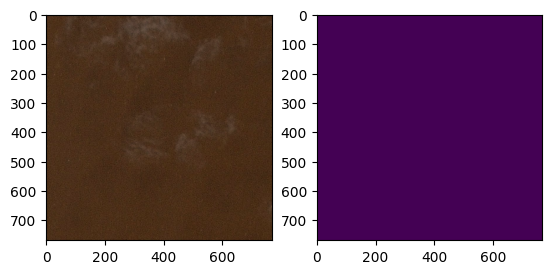

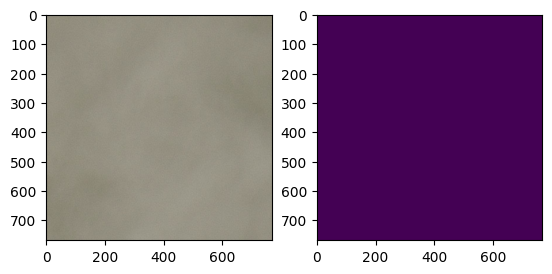

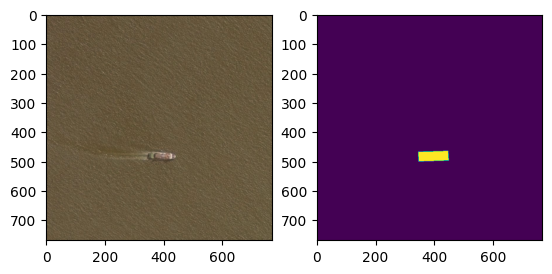

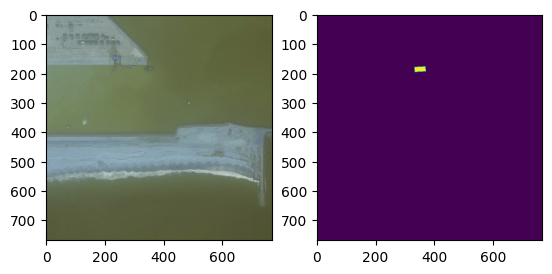

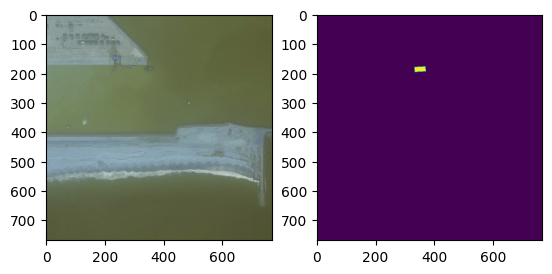

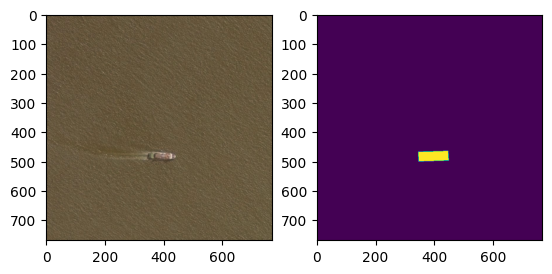

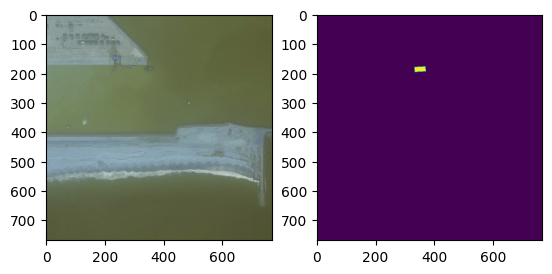

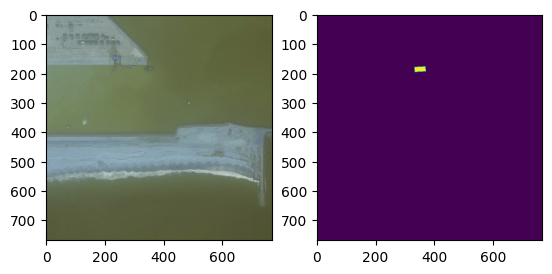

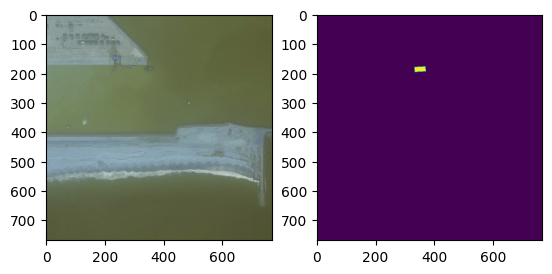

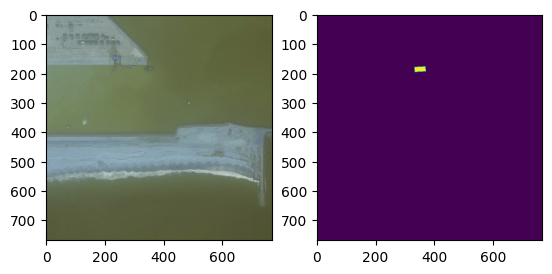

In [254]:
dirpath = "../data/raw/airbus-ship-detection/train_v2"
for file in df["ImageId"][:5]:
    image = cv2.imread(os.path.join(dirpath,file))
    mask_img = np.array(masks_as_color(df[df["ImageId"] == file]['EncodedPixels'])).astype(np.int8)*255
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img)
    plt.show()


df_no_nan = df.dropna()[:5]
for file in df_no_nan["ImageId"]:
    image = cv2.imread(os.path.join(dirpath,file))
    mask_img = np.array(masks_as_color(df[df["ImageId"] == file]['EncodedPixels'])).astype(np.int8)*255
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img)
    plt.show()

The task is clear, so let's begin development